In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import entropy
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset
from data.NoisyDataset import NoisyDataset

# Parameters

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'
activations_dir = f'{engram_dir}activations_CF/'

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


# Function to collect entropy

In [4]:
def top_n_entropy_func(n):
    def top_n_entropy(logits):
        logits = logits.squeeze()
        if n is not None:
            idxs = np.argpartition(logits, -n)[-n:]
            logits = logits[idxs]
        result = entropy(np.exp(logits), base=2)
        return result
    return top_n_entropy

In [5]:
def max_entropy(logits):
    return logits.max()

In [6]:
def eval_entropy(
    results, dset,
    ff_correct=None, clean_correct=None, pnet_correct=None,
    entropy_func=top_n_entropy_func(None)
    ):
    
    idxs = np.ones(dset.n_data).astype(bool)
    if ff_correct is not None:
        if ff_correct:
            idxs = np.logical_and(idxs, np.logical_not(dset.net_mistakes))
        else:
            idxs = np.logical_and(idxs, dset.net_mistakes)
    if clean_correct is not None:
        clean_correct_idxs = dset.labels == np.array(results['0_clean_output'])
        if clean_correct:
            idxs = np.logical_and(idxs, clean_correct_idxs)
        else:
            idxs = np.logical_and(idxs, np.logical_not(clean_correct_idxs))
    if pnet_correct is not None:
        pnet_correct_idxs = dset.labels == np.array(results['4_output'])
        if pnet_correct:
            idxs = np.logical_and(idxs, pnet_correct_idxs)
        else:
            idxs = np.logical_and(idxs, np.logical_not(pnet_correct_idxs))
    idxs = np.argwhere(idxs).squeeze()
    timesteps = []
    entropies = []
    
    n_timesteps = 5
    for i in idxs:
        label = results['label'][i]
        for t in range(n_timesteps):
            logits = results[f'{t}_logits'][i]
            entro = entropy_func(logits)
            timesteps.append(t)
            entropies.append(entro)
            
    return timesteps, entropies

# Background noises

In [7]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [8]:
bgs = ['AudScene', 'Babble8Spkr']
snrs = [-6.0, -3.0, 0.0, 3.0]

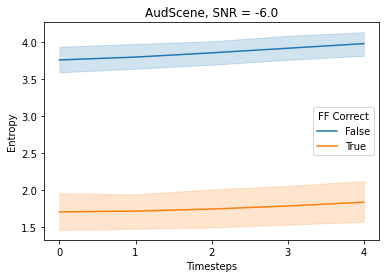

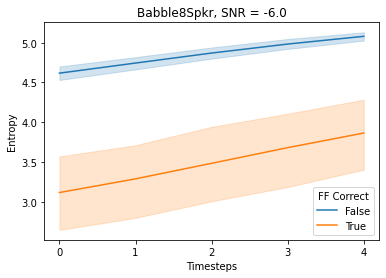

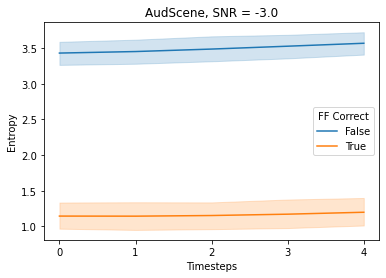

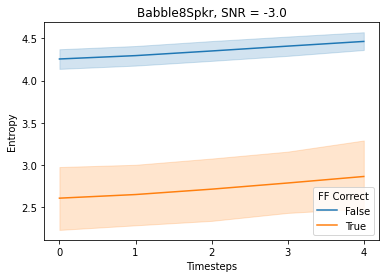

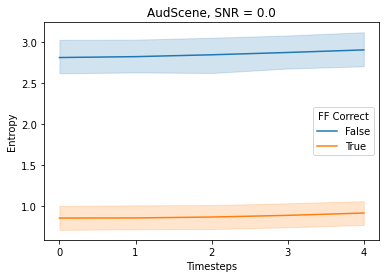

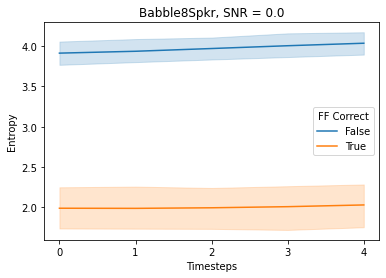

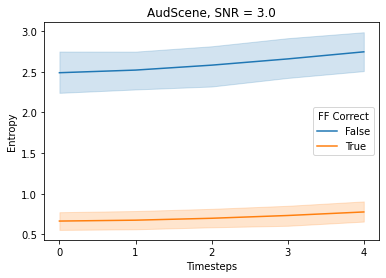

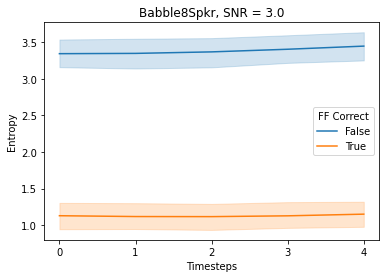

In [9]:
for snr in snrs:
    for bg in bgs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        data = {}
        data['Timesteps'] = []
        data['Entropy'] = []
        data['FF Correct'] = []
        data['PNet Correct'] = []
        for ff_correct in [True, False]:
            for pnet_correct in [True, False]:
                timesteps, entros = eval_entropy(
                    results, dset, ff_correct=ff_correct,
                    clean_correct=True, pnet_correct=pnet_correct,
                    entropy_func=top_n_entropy_func(50)
                    )
                data['Timesteps'].extend(timesteps)
                data['Entropy'].extend(entros)
                data['FF Correct'].extend([ff_correct]*len(entros))
                data['PNet Correct'].extend([pnet_correct]*len(entros))
        
        df = pd.DataFrame(data)
        fig, ax = plt.subplots()
        g = sns.lineplot(
            x='Timesteps', y='Entropy',
            hue='FF Correct', data=df, #[df['PNet Correct']==True],
            ax=ax
            )
#         g = sns.lineplot(
#             x='Timesteps', y='Entropy',
#             hue='FF Correct', data=df[df['PNet Correct']==False],
#             ax=ax, linestyle='--'
#             )
        plt.title(f'{bg}, SNR = {snr}')
        plt.xticks([0, 1, 2, 3, 4])
        plt.show()